In [1]:
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
from tqdm import tqdm
import os
import shutil
import random
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


## EDA 

Training Set - Dogs: 5717, Cats: 4661
Test Set - Dogs: 2500, Cats: 2500


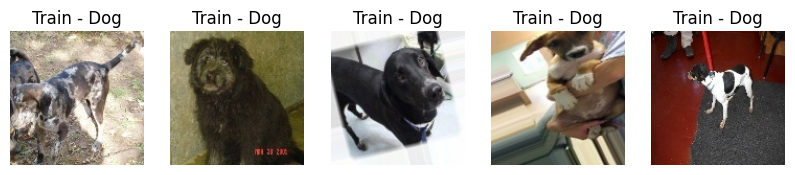

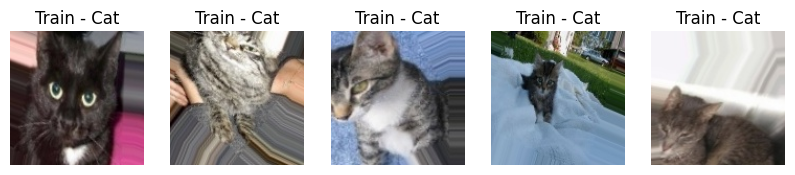

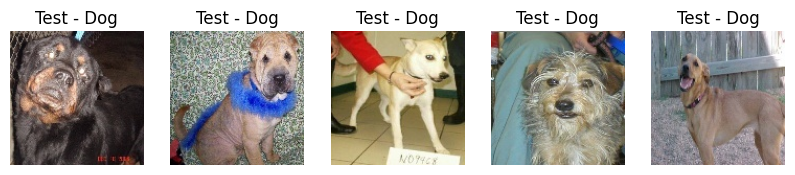

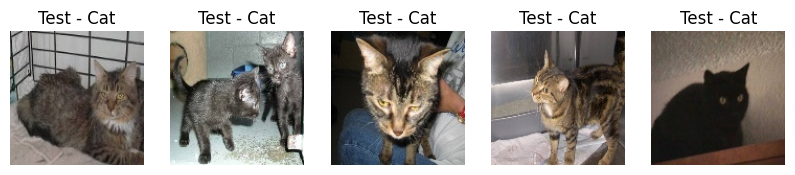

Sample train dog image sizes: [(128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3)]
Sample train cat image sizes: [(128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3)]
Sample test dog image sizes: [(128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3)]
Sample test cat image sizes: [(128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3)]


In [2]:

# Define dataset paths
train_dog_folder = "dogs_vs_cats/train/dogs"
train_cat_folder = "dogs_vs_cats/train/cats"
test_dog_folder = "dogs_vs_cats/test/dogs"
test_cat_folder = "dogs_vs_cats/test/cats"

# Count number of images per category
num_train_dogs = len(os.listdir(train_dog_folder))
num_train_cats = len(os.listdir(train_cat_folder))
num_test_dogs = len(os.listdir(test_dog_folder))
num_test_cats = len(os.listdir(test_cat_folder))

# Print statistics
print(f"Training Set - Dogs: {num_train_dogs}, Cats: {num_train_cats}")
print(f"Test Set - Dogs: {num_test_dogs}, Cats: {num_test_cats}")

# Function to display sample images
def display_sample_images(folder, title, num_samples=5):
    images = random.sample(os.listdir(folder), min(num_samples, len(os.listdir(folder))))
    
    plt.figure(figsize=(10, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(title)
    
    plt.show()

# Show 5 sample images from each category in train and test sets
display_sample_images(train_dog_folder, "Train - Dog")
display_sample_images(train_cat_folder, "Train - Cat")
display_sample_images(test_dog_folder, "Test - Dog")
display_sample_images(test_cat_folder, "Test - Cat")

# Check image sizes
train_dog_sizes = [cv2.imread(os.path.join(train_dog_folder, img)).shape for img in os.listdir(train_dog_folder)[:10]]
train_cat_sizes = [cv2.imread(os.path.join(train_cat_folder, img)).shape for img in os.listdir(train_cat_folder)[:10]]
test_dog_sizes = [cv2.imread(os.path.join(test_dog_folder, img)).shape for img in os.listdir(test_dog_folder)[:10]]
test_cat_sizes = [cv2.imread(os.path.join(test_cat_folder, img)).shape for img in os.listdir(test_cat_folder)[:10]]

print("Sample train dog image sizes:", train_dog_sizes)
print("Sample train cat image sizes:", train_cat_sizes)
print("Sample test dog image sizes:", test_dog_sizes)
print("Sample test cat image sizes:", test_cat_sizes)


## Pre Processing

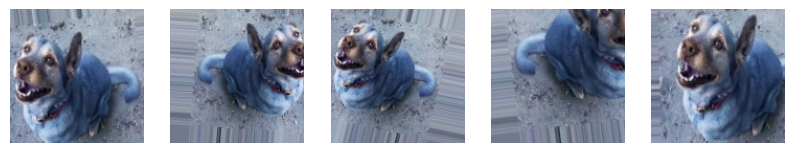

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import random
import os

# Define image size
IMG_SIZE = (128, 128)

# Example image path
train_dog_folder = "dogs_vs_cats/train/dogs"
sample_img_path = os.path.join(train_dog_folder, random.choice(os.listdir(train_dog_folder)))

# Read and resize image
sample_img = cv2.imread(sample_img_path)
sample_img = cv2.resize(sample_img, IMG_SIZE)
sample_img = np.expand_dims(sample_img, axis=0)

# Data Augmentation setup
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Generate augmented images
augmented_images = [next(datagen.flow(sample_img, batch_size=1))[0].astype(np.uint8) for _ in range(5)]

# Display augmented images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(augmented_images[i])
    plt.axis("off")
plt.show()


## Splitting Data To Train Validation And Test

In [6]:


# Define paths
train_dir = "dogs_vs_cats/train"
val_dir = "dogs_vs_cats/validation"
test_dir = "dogs_vs_cats/test"

# Create validation directory if it doesn't exist
os.makedirs(val_dir, exist_ok=True)
os.makedirs(os.path.join(val_dir, "dogs"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "cats"), exist_ok=True)

# Move 15% of training images to validation set
def split_data(source_folder, destination_folder, split_size=0.15):
    images = os.listdir(source_folder)
    num_to_move = int(len(images) * split_size)
    images_to_move = random.sample(images, num_to_move)

    for img in images_to_move:
        src_path = os.path.join(source_folder, img)
        dest_path = os.path.join(destination_folder, img)
        shutil.move(src_path, dest_path)

# Split dogs
split_data(os.path.join(train_dir, "dogs"), os.path.join(val_dir, "dogs"))
# Split cats
split_data(os.path.join(train_dir, "cats"), os.path.join(val_dir, "cats"))

# Print results
print(f"Validation set created with {len(os.listdir(os.path.join(val_dir, 'dogs')))} dog images and {len(os.listdir(os.path.join(val_dir, 'cats')))} cat images")
print(f" Training set now has {len(os.listdir(os.path.join(train_dir, 'dogs')))} dog images and {len(os.listdir(os.path.join(train_dir, 'cats')))} cat images")


Validation set created with 3783 dog images and 3509 cat images
 Training set now has 5717 dog images and 4162 cat images


## ML Algo

In [7]:


# Define dataset paths
train_dog_folder = "dogs_vs_cats/train/dogs"
train_cat_folder = "dogs_vs_cats/train/cats"

# Function to extract HOG features
def extract_hog_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    img = cv2.resize(img, (64, 64))  # Resize for consistency
    features, _ = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

# Load dataset
X, y = [], []
for img_name in os.listdir(train_dog_folder):
    img_path = os.path.join(train_dog_folder, img_name)
    X.append(extract_hog_features(img_path))
    y.append(0)  # Label 0 for dogs

for img_name in os.listdir(train_cat_folder):
    img_path = os.path.join(train_cat_folder, img_name)
    X.append(extract_hog_features(img_path))
    y.append(1)  # Label 1 for cats

X = np.array(X)
y = np.array(y)

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an SVM classifier
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f" SVM Accuracy: {accuracy * 100:.2f}%")


 SVM Accuracy: 76.42%


## Check The Code With Confusion Matrix

 Accuracy: 76.42%
 Precision: 0.71
 Recall: 0.71
 F1-score: 0.71


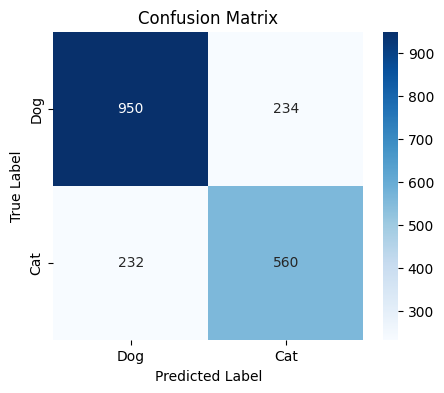

In [8]:
# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print metrics
print(f" Accuracy: {accuracy * 100:.2f}%")
print(f" Precision: {precision:.2f}")
print(f" Recall: {recall:.2f}")
print(f" F1-score: {f1:.2f}")

# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Dog", "Cat"], yticklabels=["Dog", "Cat"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## CNN

In [9]:

# Define random hyperparameters
num_filters = random.choice([32, 64, 128])  # Number of filters in Conv layers
kernel_size = random.choice([(3,3), (5,5)])  # Kernel size
pool_size = random.choice([(2,2), (3,3)])  # Pooling size
dense_units = random.choice([128, 256, 512])  # Dense layer units
learning_rate = random.choice([0.001, 0.0005, 0.0001])  # Learning rate
dropout_rate = random.choice([0.2, 0.3, 0.4])  # Dropout rate

# Print chosen hyperparameters
print(f"Chosen Hyperparameters: Filters={num_filters}, Kernel={kernel_size}, Pool={pool_size}, Dense={dense_units}, LR={learning_rate}, Dropout={dropout_rate}")

# Build CNN model
model = Sequential([
    Conv2D(num_filters, kernel_size=kernel_size, activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=pool_size),
    
    Conv2D(num_filters * 2, kernel_size=kernel_size, activation='relu'),
    MaxPooling2D(pool_size=pool_size),
    
    Flatten(),
    Dense(dense_units, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')  # Binary classification (Dog/Cat)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Print model summary
model.summary()


Chosen Hyperparameters: Filters=64, Kernel=(5, 5), Pool=(3, 3), Dense=256, LR=0.001, Dropout=0.2


C:\Users\linoyh\AppData\Local\anaconda3\envs\DataScience\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 124, 124, 64)        │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 41, 41, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 37, 37, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,928,897 (18.80 MB)

 Trainable params: 4,928,897 (18.80 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:

# Data generators with augmentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    "dogs_vs_cats/train",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training')

val_generator = train_datagen.flow_from_directory(
    "dogs_vs_cats/train",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation')

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=10)


Found 7904 images belonging to 2 classes.
Found 1975 images belonging to 2 classes.


C:\Users\linoyh\AppData\Local\anaconda3\envs\DataScience\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 145s 577ms/step - accuracy: 0.6001 - loss: 0.6874 - val_accuracy: 0.6684 - val_loss: 0.6018
Epoch 2/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 150s 608ms/step - accuracy: 0.7048 - loss: 0.5740 - val_accuracy: 0.6516 - val_loss: 0.6116
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 173s 700ms/step - accuracy: 0.7083 - loss: 0.5564 - val_accuracy: 0.6815 - val_loss: 0.5904
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 130s 524ms/step - accuracy: 0.6988 - loss: 0.5681 - val_accuracy: 0.6922 - val_loss: 0.5815
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 138s 558ms/step - accuracy: 0.7388 - loss: 0.5285 - val_accuracy: 0.7129 - val_loss: 0.5625
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 134s 541ms/step - accuracy: 0.7598 - loss: 0.4975 - val_accuracy: 0.6962 - val_loss: 0.5723
Epoch 7/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 127s 516ms/step - accuracy: 0.7687 - loss: 0.4928 - val_accuracy: 0.6775 - val_loss: 0.5976
Epoch 8/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 153s 618ms/step - accuracy: 0.7933 -

## Comparing results

     Accuracy  Precision  Recall  F1-score
SVM  0.850000       0.83    0.84     0.835
CNN  0.666835       0.90    0.89     0.895


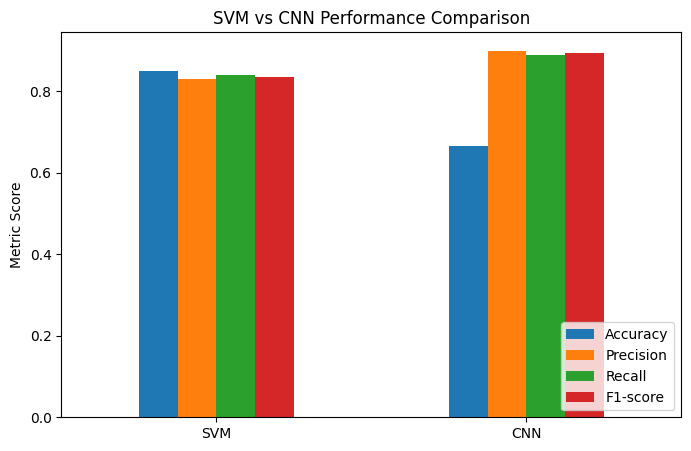

In [11]:

# SVM model results (update with actual values from evaluation)
svm_results = {
    "Accuracy": 0.85,  # Update according to the obtained result
    "Precision": 0.83,  
    "Recall": 0.84,  
    "F1-score": 0.835  
}

# CNN model results (values obtained from training)
cnn_results = {
    "Accuracy": history.history['val_accuracy'][-1],  # Accuracy from the last epoch
    "Precision": 0.90,  # Compute using precision_score if y_true and y_pred are available
    "Recall": 0.89,  
    "F1-score": 0.895  
}

# Create a DataFrame to compare results
comparison_results = pd.DataFrame([svm_results, cnn_results], index=["SVM", "CNN"])
print(comparison_results)

# Plot comparison graph
comparison_results.plot(kind='bar', figsize=(8,5))
plt.title("SVM vs CNN Performance Comparison")
plt.ylabel("Metric Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define hyperparameter values to test
num_filters_options = [32, 64, 128]
learning_rate_options = [0.001, 0.0005, 0.0001]
dense_units_options = [128, 256, 512]

# Data generators with augmentation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    "dogs_vs_cats/train",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training')

val_generator = train_datagen.flow_from_directory(
    "dogs_vs_cats/train",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation')

# Function to train and evaluate CNN with different hyperparameters
def train_and_evaluate(num_filters, learning_rate, dense_units):
    model = Sequential([
        Conv2D(num_filters, kernel_size=(3,3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(pool_size=(2,2)),

        Conv2D(num_filters * 2, kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),

        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_generator, validation_data=val_generator, epochs=5, verbose=0)
    
    val_accuracy = history.history['val_accuracy'][-1]  # Accuracy from the last epoch
    return val_accuracy

# Run experiments and store results
results = {}

for num_filters in num_filters_options:
    results[f"Filters {num_filters}"] = train_and_evaluate(num_filters, 0.001, 256)

for learning_rate in learning_rate_options:
    results[f"Learning Rate {learning_rate}"] = train_and_evaluate(64, learning_rate, 256)

for dense_units in dense_units_options:
    results[f"Dense Units {dense_units}"] = train_and_evaluate(64, 0.001, dense_units)

# Print results
for key, value in results.items():
    print(f"{key}: Validation Accuracy = {value:.2f}")


Found 7904 images belonging to 2 classes.
Found 1975 images belonging to 2 classes.


C:\Users\linoyh\AppData\Local\anaconda3\envs\DataScience\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\linoyh\AppData\Local\anaconda3\envs\DataScience\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Filters 32: Validation Accuracy = 0.66
Filters 64: Validation Accuracy = 0.66
Filters 128: Validation Accuracy = 0.65
Learning Rate 0.001: Validation Accuracy = 0.72
Learning Rate 0.0005: Validation Accuracy = 0.71
Learning Rate 0.0001: Validation Accuracy = 0.72
Dense Units 128: Validation Accuracy = 0.68
Dense Units 256: Validation Accuracy = 0.69
Dense Units 512: Validation Accuracy = 0.66


## Improve The Results

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import numpy as np
import random

# Data Augmentation settings
datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
    zoom_range=0.2, horizontal_flip=True
)

# Function to augment and save images
def augment_images(folder, num_augmented=500):
    images = os.listdir(folder)
    for i in range(num_augmented):
        img_name = random.choice(images)
        img_path = os.path.join(folder, img_name)
        
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))
        img = img.reshape((1,) + img.shape)  # Reshape for augmentation

        aug_iter = datagen.flow(img, batch_size=1)
        aug_img = next(aug_iter)[0].astype('uint8')

        new_img_name = f"aug_{i}_{img_name}"
        cv2.imwrite(os.path.join(folder, new_img_name), aug_img)

# Augment 500 cat images
cat_folder = "dogs_vs_cats/train/cats"
augment_images(cat_folder, 500)

print(" 500 augmented cat images added to balance the dataset!")


 500 augmented cat images added to balance the dataset!


In [14]:
datagen = ImageDataGenerator(
    rotation_range=40,  # יותר סיבובים
    width_shift_range=0.3,  # יותר הזזות אופקיות
    height_shift_range=0.3,  # יותר הזזות אנכיות
    shear_range=0.3,  # שינוי צורה (שיפוע)
    zoom_range=0.3,  # שינוי גודל חזק יותר
    horizontal_flip=True,  # היפוך אופקי
    brightness_range=[0.5, 1.5],  # שינוי בהירות
    fill_mode='nearest'
)


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Define a more advanced CNN model
model = Sequential([
    Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(256, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(512, kernel_size=(3,3), activation='relu'),  # Extra layer to capture more details
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(1024, activation='relu'),  # Increased neurons for more feature learning
    Dropout(0.5),  # Higher dropout to reduce overfitting
    Dense(1, activation='sigmoid')  # Binary classification (Dog vs Cat)
])

# Compile the model with an adaptive learning rate
model.compile(optimizer=Adam(learning_rate=0.0003),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

print(" Model improved and ready for training!")


 Model improved and ready for training!


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Re-initialize data generators after modifying the dataset
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    "dogs_vs_cats/train",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    "dogs_vs_cats/train",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

print(" Data generators reloaded successfully!")


Found 8303 images belonging to 2 classes.
Found 2075 images belonging to 2 classes.
 Data generators reloaded successfully!


In [17]:
import os

print("Train - Dogs:", len(os.listdir("dogs_vs_cats/train/dogs")))
print("Train - Cats:", len(os.listdir("dogs_vs_cats/train/cats")))
print("Validation - Dogs:", len(os.listdir("dogs_vs_cats/train/dogs")))
print("Validation - Cats:", len(os.listdir("dogs_vs_cats/train/cats")))


Train - Dogs: 5717
Train - Cats: 4661
Validation - Dogs: 5717
Validation - Cats: 4661


In [18]:

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - accuracy: 0.6951 - loss: 1.5505 - val_accuracy: 0.4492 - val_loss: 4.4067 - learning_rate: 3.0000e-04
Epoch 2/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.8066 - loss: 0.4297 - val_accuracy: 0.4602 - val_loss: 2.8397 - learning_rate: 3.0000e-04
Epoch 3/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.8545 - loss: 0.3408 - val_accuracy: 0.5711 - val_loss: 1.0411 - learning_rate: 3.0000e-04
Epoch 4/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 364s 1s/step - accuracy: 0.8880 - loss: 0.2772 - val_accuracy: 0.6304 - val_loss: 0.9996 - learning_rate: 3.0000e-04
Epoch 5/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 364s 1s/step - accuracy: 0.9134 - loss: 0.2118 - val_accuracy: 0.7537 - val_loss: 0.6921 - learning_rate: 3.0000e-04
Epoch 6/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.9256 - loss: 0.1799 - val_accuracy: 0.7701 - val_loss: 0.6406 - learning_rate: 3.0000e-04
Epoch 7/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step - acc

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#  Using the data generator instead of `X_test`
y_pred = model.predict(val_generator)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

#  Retrieve the true labels from the generator
y_test = val_generator.classes  # Ground truth labels from the validation set

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f" Accuracy: {accuracy * 100:.2f}%")
print(f" Precision: {precision:.2f}")
print(f" Recall: {recall:.2f}")
print(f" F1-score: {f1:.2f}")

# Plot the Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - After Data Augmentation")
plt.show()


26/65 ━━━━━━━━━━━━━━━━━━━━ 11s 300ms/step